<a href="https://colab.research.google.com/github/BehzadBarati/Ingredient-Maps/blob/main/Food_Recipes_RecipeNLG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Abstract:

This notebook produces elementary reports on RecipeNLG dataset which contains more than 2 million recipies of foods.
___
Source:

My main refrences are [RecipeNLG paper](https://www.aclweb.org/anthology/2020.inlg-1.4.pdf) and its [dataset](https://recipenlg.cs.put.poznan.pl).
___
Input: 

1- Dataset of RecipeNLG

Ouput:

1- EDA report on RecipeNLG dataset (both inline report and HTML file)

2- word cloud pictures
___
Hints:

1_ As our csv file is greater than 2 gigabytes, I prefer to use cloud services(here google colab). I uploaded RecipeNLG dataset in my [google drive](https://drive.google.com/drive/folders/1g1ZNYKlLN4hyP8ywHXWa2Iu1oQ4wxSgR?usp=sharing). It is public.

2_ If there is out of memory error in running "ProfileReport", please first install latest version of "pandas_profiling" library, then try "minimal=True" argument in "profileReport" for eliminating some calculations. (pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip)

# Import needed libraries

In [1]:
import pandas as pd 
from wordcloud import WordCloud             #for making wordcloud pictures
from pandas_profiling import ProfileReport  #for observing our dataframe very quickly
import matplotlib.pyplot as plt

# load data

Source: This [article](https://medium.com/analytics-vidhya/how-to-fetch-kaggle-datasets-into-google-colab-ea682569851a) help me in loading data.

our dataset will be read as ***recipe_df*** .

In [2]:
# Mount google drive to colab notebook

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
cd gdrive/MyDrive/Projects/Ingredient-Maps/

/content/gdrive/MyDrive/Projects/Ingredient-Maps


In [4]:
# Reading file and check if data is loaded

recipe_df = pd.read_csv('./dataset/full_dataset.csv')
print('Number of recipes in dataset: ', len(recipe_df))
print('last 5 recipes:')
recipe_df.tail(5)

Number of recipes in dataset:  2231142
last 5 recipes:


,Unnamed: 0,title,ingredients,directions,link,source,NER
2231137,2231137,Sunny's Fake Crepes,"[""1/2 cup chocolate hazelnut spread (recommend...","[""Spread hazelnut spread on 1 side of each tor...",www.foodnetwork.com/recipes/sunny-anderson/sun...,Recipes1M,"[""chocolate hazelnut spread"", ""tortillas"", ""bu..."
2231138,2231138,Devil Eggs,"[""1 dozen eggs"", ""1 paprika"", ""1 salt and pepp...","[""Boil eggs on medium for 30mins."", ""Then cool...",cookpad.com/us/recipes/355411-devil-eggs,Recipes1M,"[""eggs"", ""paprika"", ""salt"", ""choice"", ""miracle..."
2231139,2231139,Extremely Easy and Quick - Namul Daikon Salad,"[""150 grams Daikon radish"", ""1 tbsp Sesame oil...","[""Julienne the daikon and squeeze out the exce...",cookpad.com/us/recipes/153324-extremely-easy-a...,Recipes1M,"[""radish"", ""Sesame oil"", ""White sesame seeds"",..."
2231140,2231140,Pan-Roasted Pork Chops With Apple Fritters,"[""1 cup apple cider"", ""6 tablespoons sugar"", ""...","[""In a large bowl, mix the apple cider with 4 ...",cooking.nytimes.com/recipes/1015164,Recipes1M,"[""apple cider"", ""sugar"", ""kosher salt"", ""bay l..."
2231141,2231141,Polpette in Spicy Tomato Sauce,"[""1 pound ground veal"", ""1/2 pound sweet Itali...","[""Preheat the oven to 350."", ""In a bowl, mix t...",www.foodandwine.com/recipes/polpette-spicy-tom...,Recipes1M,"[""ground veal"", ""sausage"", ""bread crumbs"", ""mi..."


# EDA

In [5]:
print(recipe_df.columns)

Index(['Unnamed: 0', 'title', 'ingredients', 'directions', 'link', 'source',
       'NER'],
      dtype='object')


In [6]:
# generate a quick report from our dataset 

profile = ProfileReport(recipe_df, minimal=True)
profile.to_file("EDA-Report-RecipeNLG.html")
profile

Summarize dataset:   0%|          | 0/15 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
# for creating word clouds, I used WordCloud library which was imported before.

def minimal_wordcloud(df, column):
    """
    Generate a simple wordcloud similar to: 
    https://www.kaggle.com/paultimothymooney/explore-recipe-nlg-dataset/data.
    The only import required is: from wordcloud import WordCloud
    """
    text = str(df[column].values)
    wordcloud = WordCloud().generate(text)
    image = wordcloud.to_image()
    plt.axis("off")
    plt.imshow(image)
    plt.show()


world cloud of contents in column title


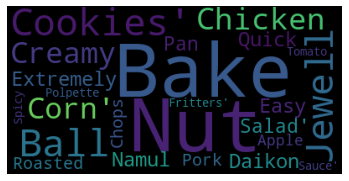


world cloud of contents in column ingredients


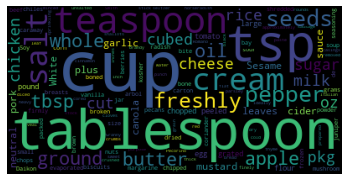


world cloud of contents in column directions


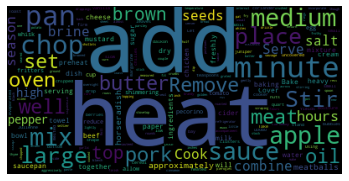


world cloud of contents in column link


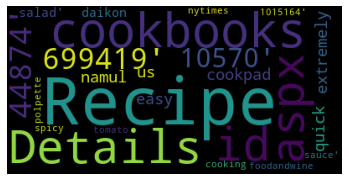


world cloud of contents in column source


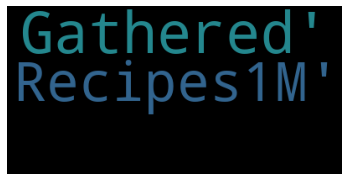


world cloud of contents in column NER


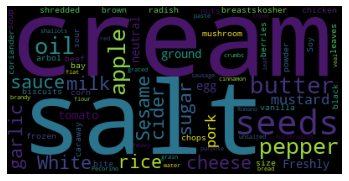

In [8]:
# print word clouds

for c in recipe_df.columns[1:]:
    print('\nworld cloud of contents in column {}'.format(c))
    minimal_wordcloud(recipe_df, c)